**1. Import Libraries & Setup**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score
)

from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer

import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks as cf

cf.go_offline()
cf.set_config_file(world_readable=True, theme='pearl')

nltk.download('wordnet', quiet=True)


True

**2. Define Cleaning & Preprocessing Functions**

In [ ]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's'])
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(TEXT_CLEANING_RE, ' ', text)
    return " ".join([word for word in text.split() if word not in STOPWORDS])

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


**3. Load and Preprocess the Dataset**

In [ ]:
print("\nLoading and preprocessing dataset...")
df = pd.read_csv("cyberbullying_tweets.csv")
df['clean_text'] = df['tweet_text'].apply(clean_text).apply(lemmatize_words)



Loading and preprocessing dataset...


**4. N-Gram Extraction & Visualization Function**

In [ ]:
def get_top_n_gram(corpus, ngram_range, n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

def plot_insights(subtype, title):
    subset = df[df['cyberbullying_type'] == subtype]
    text = subset.clean_text.values

    plt.figure(figsize=(20, 10))
    cloud = WordCloud(background_color='black', colormap="Dark2", collocations=False,
                     width=2000, height=1000).generate(" ".join(text))
    plt.axis('off')
    plt.title(title, fontsize=40)
    plt.imshow(cloud)
    plt.show()

    unigrams = get_top_n_gram(text, (1, 1), 10)
    bigrams = get_top_n_gram(text, (2, 2), 10)

    uni_df = pd.DataFrame(unigrams, columns=['Text', 'Count'])
    bi_df = pd.DataFrame(bigrams, columns=['Text', 'Count'])

    px.bar(uni_df, x='Text', y='Count', title=f"{title} - Top Unigrams", color_discrete_sequence=['black']).show()
    px.bar(bi_df, x='Text', y='Count', title=f"{title} - Top Bigrams", color_discrete_sequence=['black']).show()


**5. Generate Visualizations by Cyberbullying Type**


===== Generating Visualizations for Different Cyberbullying Types =====


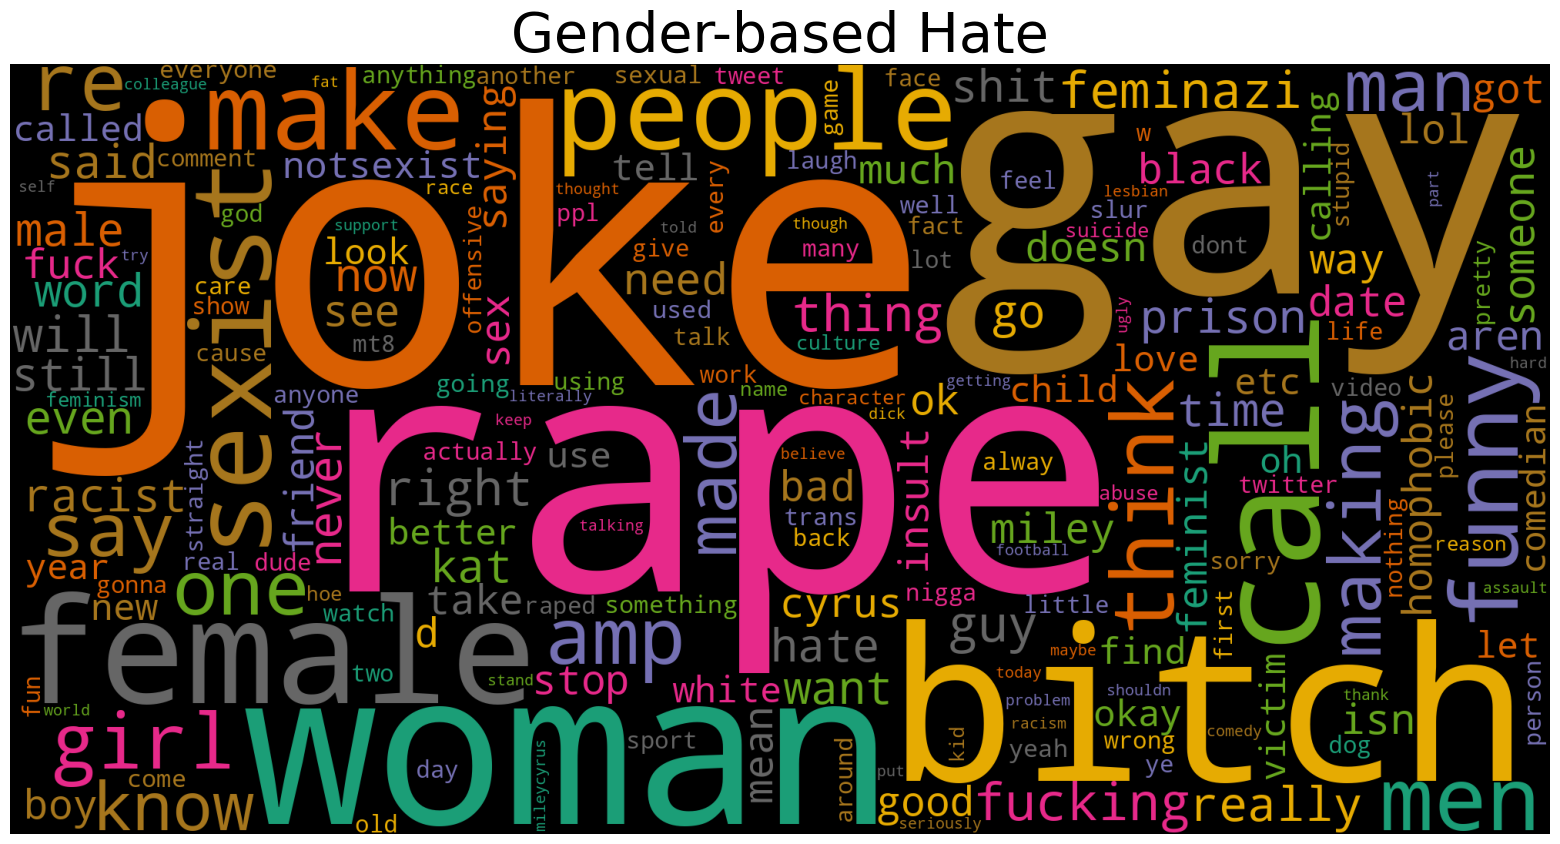

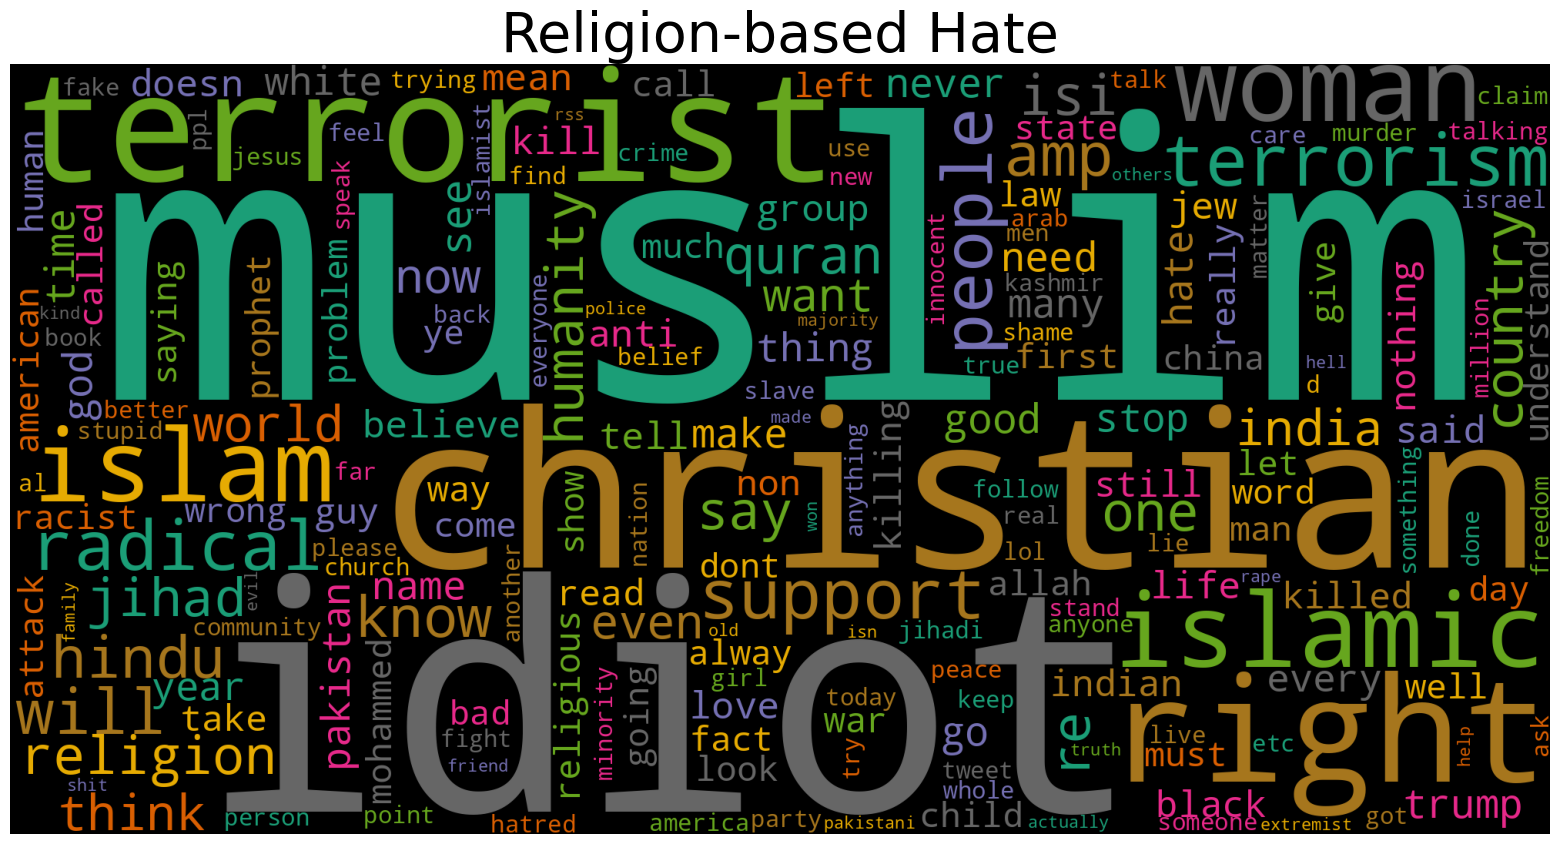

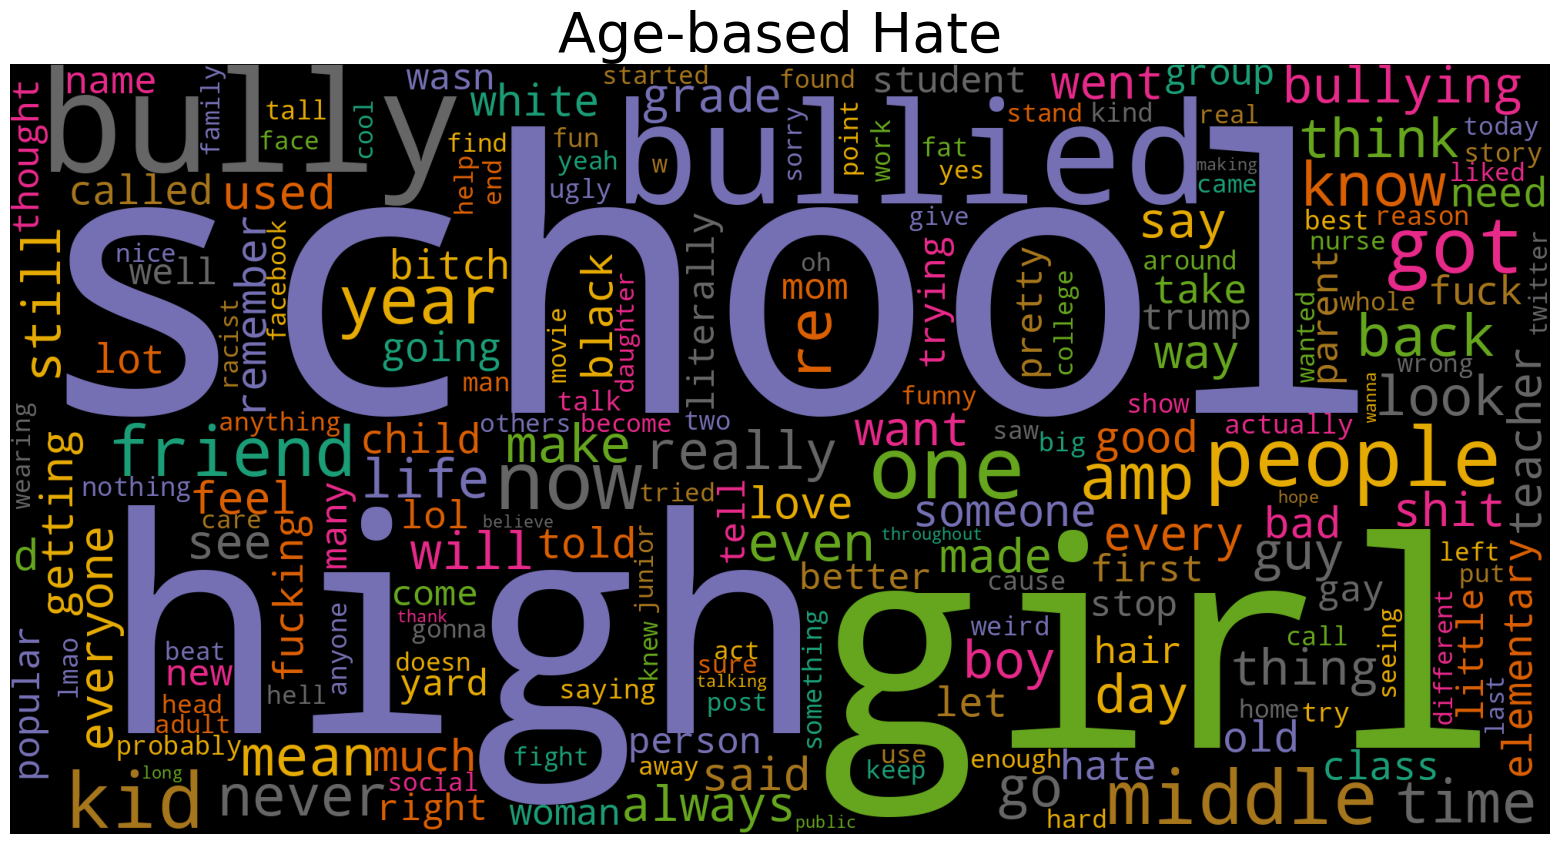

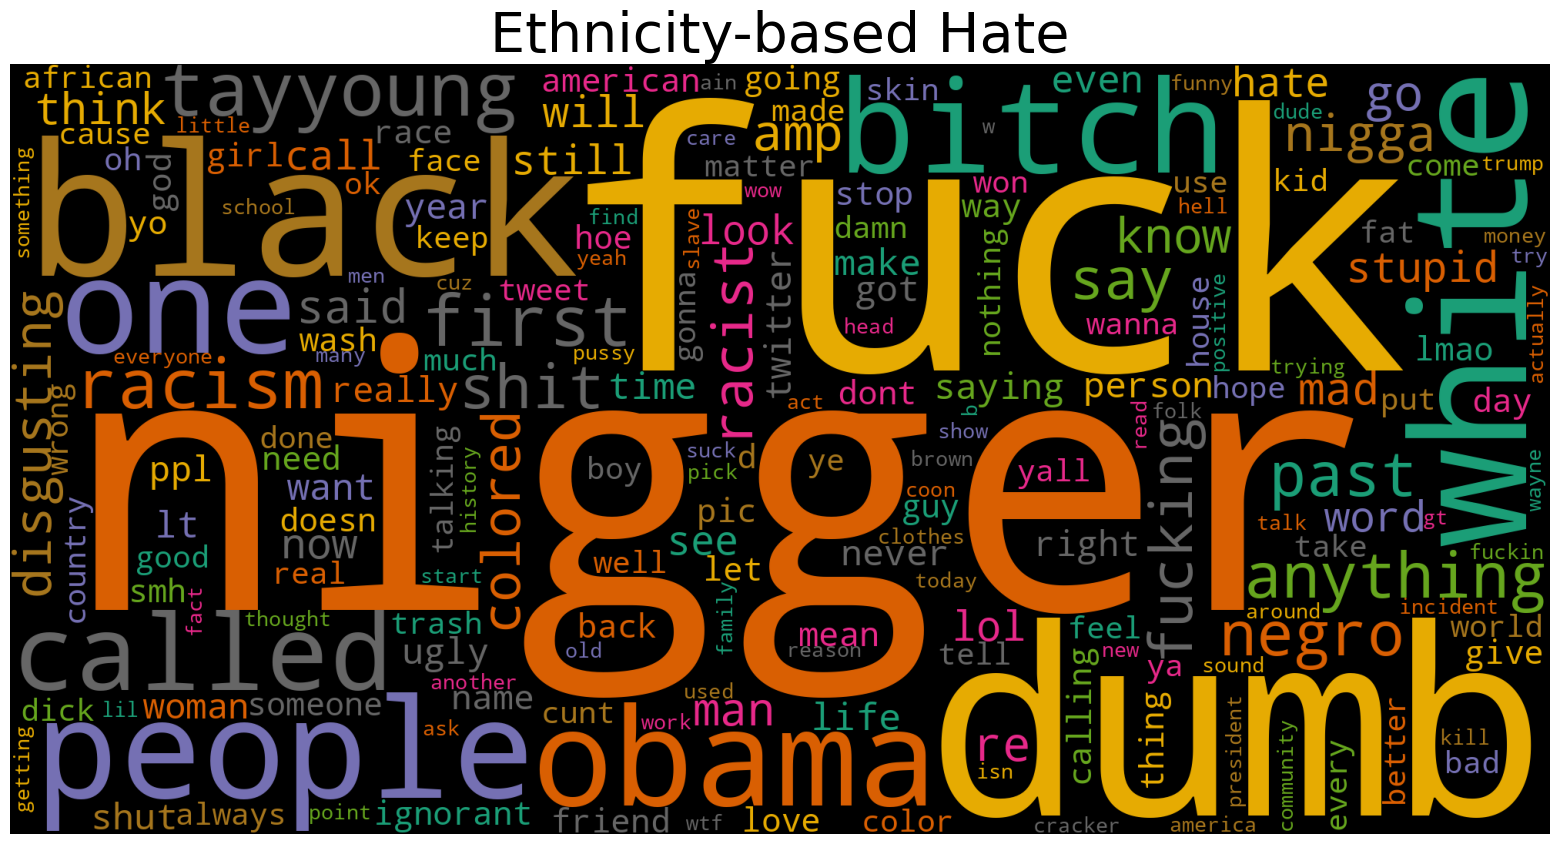

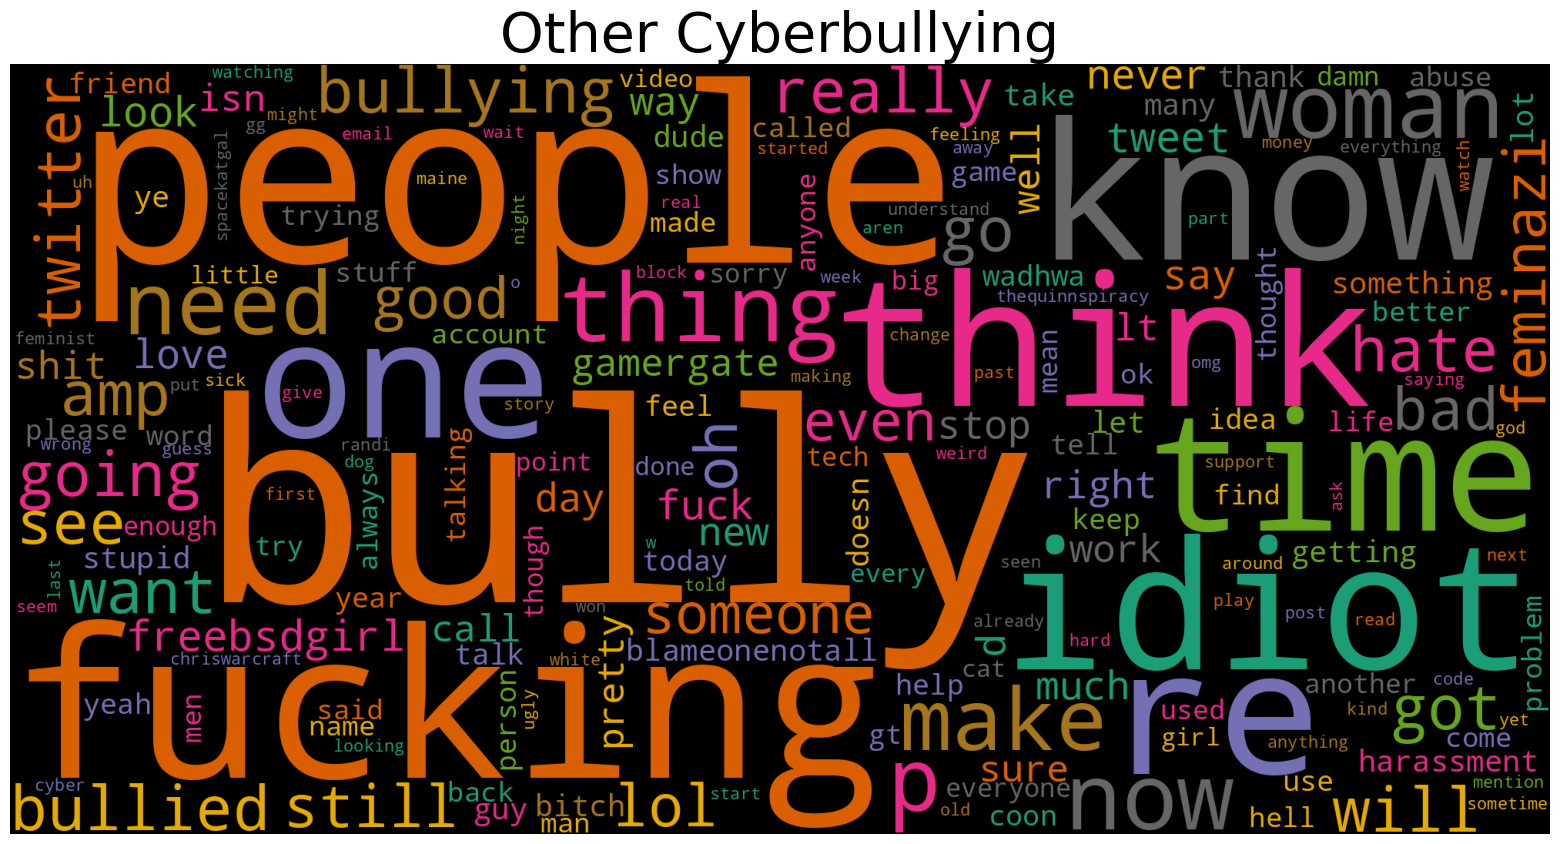

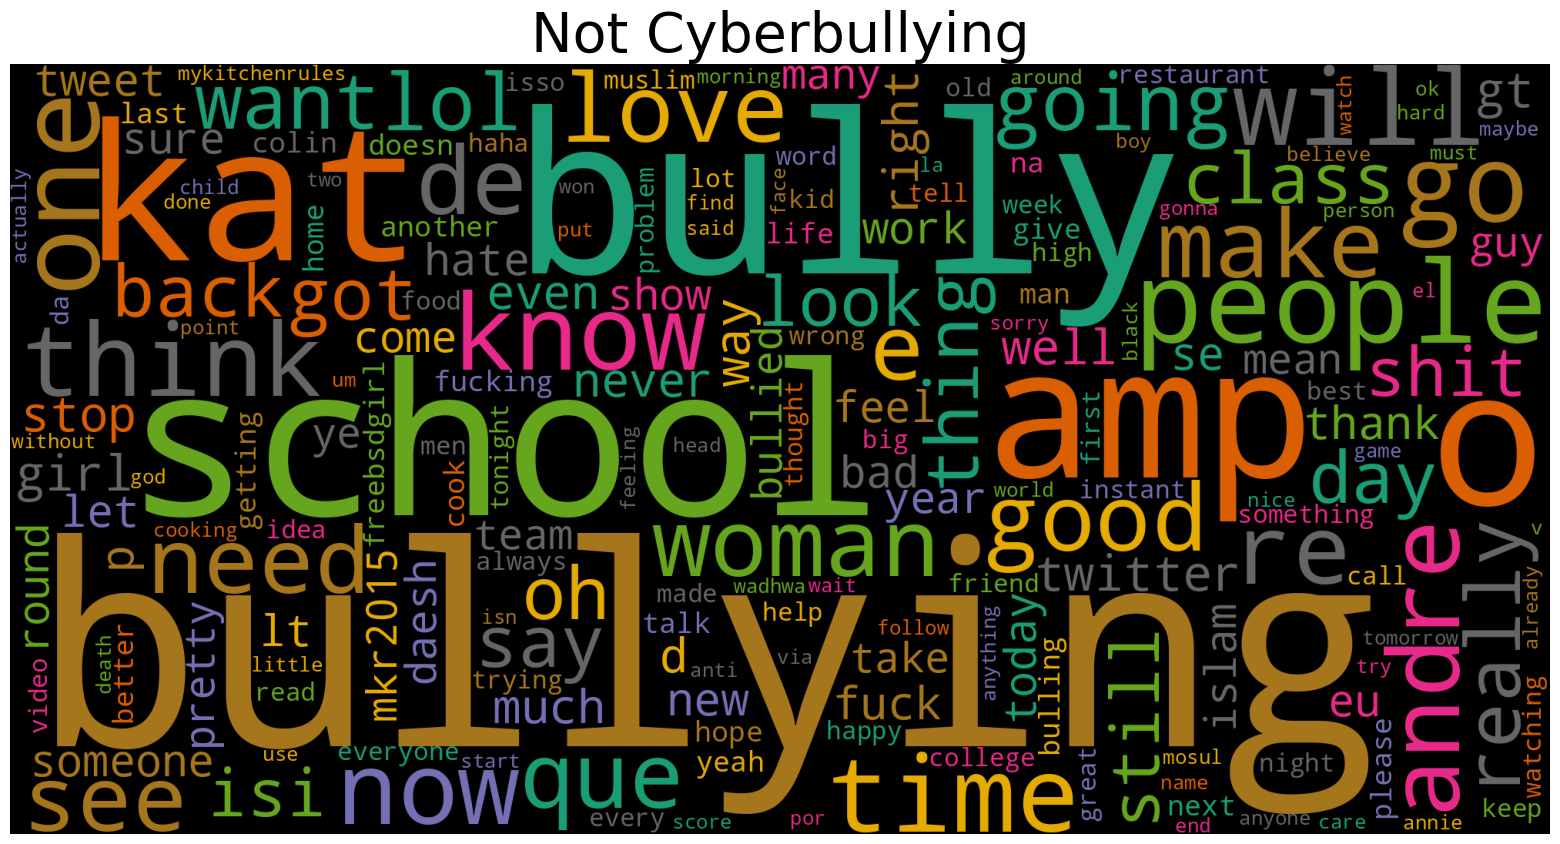

In [ ]:
print("\n===== Generating Visualizations for Different Cyberbullying Types =====")
types = ['gender', 'religion', 'age', 'ethnicity', 'other_cyberbullying', 'not_cyberbullying']
titles = ['Gender-based Hate', 'Religion-based Hate', 'Age-based Hate',
          'Ethnicity-based Hate', 'Other Cyberbullying', 'Not Cyberbullying']

for t, title in zip(types, titles):
    plot_insights(t, title)


**6. Data Distribution Visualization**


===== Distribution of Cyberbullying Types =====
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


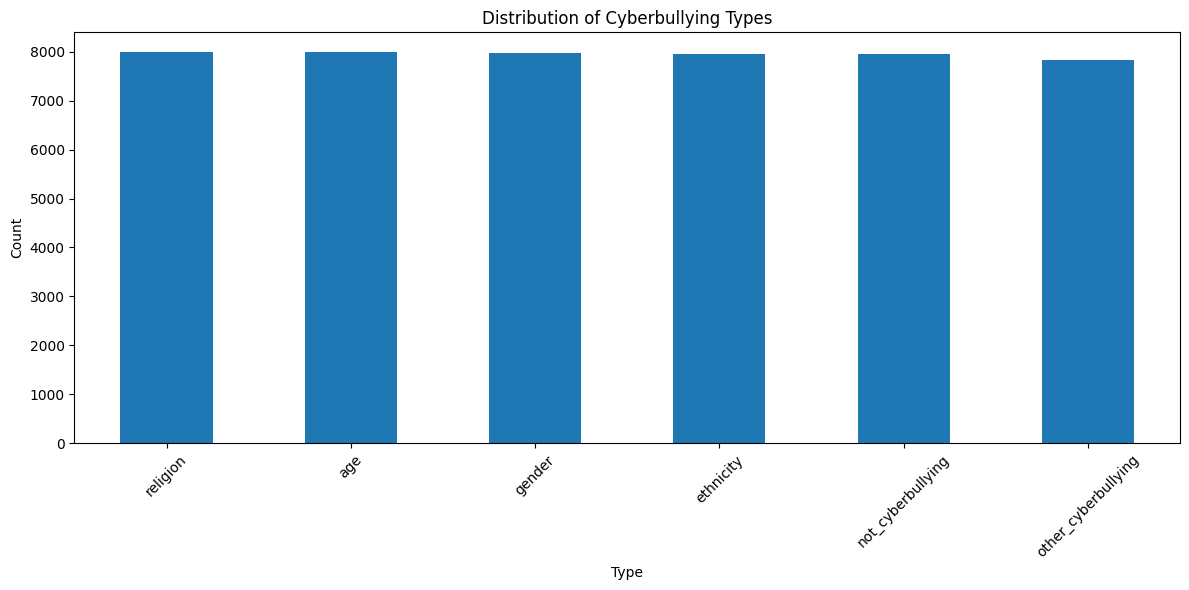

In [ ]:
print("\n===== Distribution of Cyberbullying Types =====")
type_counts = df['cyberbullying_type'].value_counts()
print(type_counts)
type_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of Cyberbullying Types')
plt.ylabel('Count')
plt.xlabel('Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**7. Encode Labels & Train Model**

In [ ]:
df['label'] = df['cyberbullying_type'].astype('category').cat.codes
label_mapping = dict(enumerate(df['cyberbullying_type'].astype('category').cat.categories))
reverse_mapping = {v: k for k, v in label_mapping.items()}

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_vec, y_train)
print("Model training complete!")


Model training complete!


**8. Prediction Function**

In [ ]:
def predict_cyberbullying(text):
    cleaned_text = lemmatize_words(clean_text(text))
    text_vec = vectorizer.transform([cleaned_text])
    predicted_class = model.predict(text_vec)[0]
    probabilities = model.predict_proba(text_vec)[0]

    return {
        "is_cyberbullying": predicted_class != reverse_mapping.get("not_cyberbullying", -1),
        "cyberbullying_type": label_mapping[predicted_class],
        "confidence": probabilities[predicted_class],
        "all_probabilities": {label_mapping[i]: prob for i, prob in enumerate(probabilities)},
        "cleaned_text": cleaned_text
    }


**9. Evaluate Model & Show Insights**


===== Model Evaluation =====
Accuracy: 0.7332

Classification Report:
                     precision    recall  f1-score   support

                age       0.70      0.98      0.82      1603
          ethnicity       0.81      0.87      0.84      1603
             gender       0.75      0.84      0.79      1531
  not_cyberbullying       0.68      0.33      0.45      1624
other_cyberbullying       0.62      0.42      0.50      1612
           religion       0.78      0.97      0.86      1566

           accuracy                           0.73      9539
          macro avg       0.72      0.74      0.71      9539
       weighted avg       0.72      0.73      0.71      9539


Generating Confusion Matrix...


<Figure size 1200x1000 with 0 Axes>

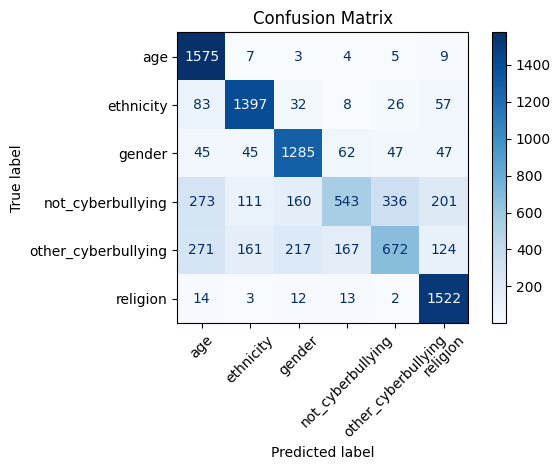

In [ ]:
print("\n===== Model Evaluation =====")
y_pred = model.predict(X_test_vec)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.values()))

print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.values())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


**10. Show Sample Predictions + Feature Importance**

In [ ]:
print("\n===== Sample Predictions from Test Set =====")
for i in range(5):
    print(f"Tweet: {X_test.iloc[i]}")
    print(f"Actual: {label_mapping[y_test.iloc[i]]}")
    print(f"Predicted: {label_mapping[y_pred[i]]}\n")

print("\n===== Feature Importance Analysis =====")
feature_names = vectorizer.get_feature_names_out()
for i, category in label_mapping.items():
    indices = np.argsort(model.feature_log_prob_[i])[-10:]
    important_features = [feature_names[j] for j in indices]
    print(f"Top 10 features for {category}: {', '.join(important_features)}")



===== Sample Predictions from Test Set =====
Tweet: hahaha ain even worth tweet dumb fuck knw diff nigga amp nigger
Actual: ethnicity
Predicted: ethnicity

Tweet: hsaymssik suck smile wiped face huh kat glass house throw stone mkr2015
Actual: gender
Predicted: gender

Tweet: reminder absolutely disgusting see people prank call saying wasup nig throw food friend lunch making monkey noise tweet nigger joke act care black life please fuck
Actual: ethnicity
Predicted: ethnicity

Tweet: buzzfeeduk accidentally open front camera
Actual: other_cyberbullying
Predicted: other_cyberbullying

Tweet: loving look fritter
Actual: not_cyberbullying
Predicted: not_cyberbullying


===== Feature Importance Analysis =====
Top 10 features for age: friend, people, got, kid, middle, bullied, bully, girl, high, school
Top 10 features for ethnicity: called, people, bitch, white, tayyoung, obama, black, dumb, fuck, nigger
Top 10 features for gender: people, funny, make, woman, sexist, bitch, female, gay, rape

**11. Text Analysis & Visualization Functions**

In [ ]:
def visualize_text_analysis(text, result):
    plt.figure(figsize=(12, 6))
    cloud = WordCloud(background_color='white', colormap="viridis", collocations=False,
                     width=800, height=400).generate(result["cleaned_text"])
    plt.axis('off')
    plt.title("WordCloud of Input Text", fontsize=16)
    plt.imshow(cloud)
    plt.show()

    categories = list(result["all_probabilities"].keys())
    probs = list(result["all_probabilities"].values())

    sorted_indices = np.argsort(probs)
    categories = [categories[i] for i in sorted_indices]
    probs = [probs[i] for i in sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(categories, probs)
    plt.xlabel('Probability')
    plt.title('Cyberbullying Type Probabilities')
    plt.tight_layout()
    plt.show()


**12. Interactive Text Analyzer**

In [ ]:
def analyze_text():
    while True:
        user_input = input("\nEnter text to analyze (or 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        result = predict_cyberbullying(user_input)

        print("\n--- Prediction Results ---")
        if result["is_cyberbullying"]:
            print(f"⚠️ Cyberbullying detected: {result['cyberbullying_type']}")
        else:
            print("✅ No cyberbullying detected")
        print(f"Confidence: {result['confidence']:.2f}")

        print("\nProbability breakdown:")
        for bullying_type, prob in sorted(result["all_probabilities"].items(), key=lambda x: x[1], reverse=True):
            print(f"{bullying_type}: {prob:.4f}")

        visualize_text_analysis(user_input, result)

        if result["is_cyberbullying"]:
            print(f"\nSimilar examples of {result['cyberbullying_type']} from the dataset:")
            similar = df[df['cyberbullying_type'] == result["cyberbullying_type"]]['tweet_text'].sample(
                min(3, sum(df['cyberbullying_type'] == result["cyberbullying_type"]))
            ).tolist()
            for i, example in enumerate(similar, 1):
                print(f"{i}. {example}")


**13. Main Function to Launch App**


===== Cyberbullying Detection System =====
This system analyzes text for different types of cyberbullying.

Options:
1. Analyze text for cyberbullying
2. Exit

Enter your choice (1-2): 1

Enter text to analyze (or 'exit' to quit): fucking bitch

--- Prediction Results ---
⚠️ Cyberbullying detected: ethnicity
Confidence: 0.48

Probability breakdown:
ethnicity: 0.4751
gender: 0.3289
other_cyberbullying: 0.0982
age: 0.0766
not_cyberbullying: 0.0147
religion: 0.0065


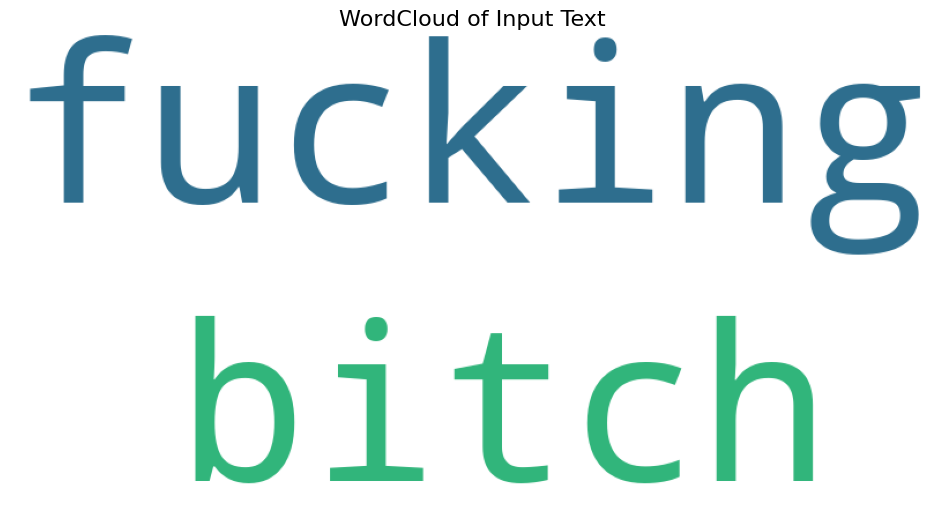

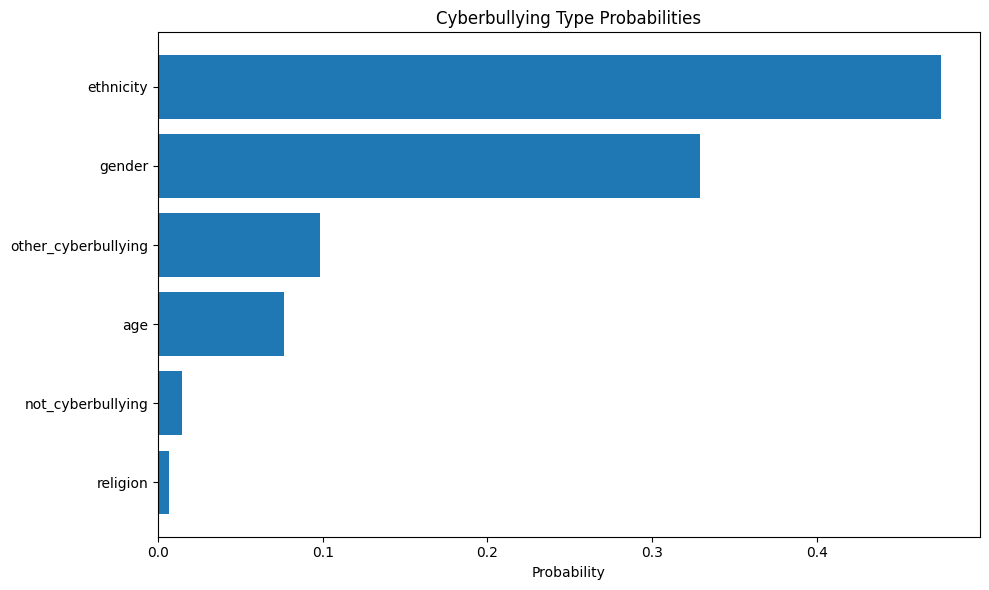


Similar examples of ethnicity from the dataset:
1. actually us negros whipped white people and called them karens in the process so ://
2. U dumb nigger and lil shithead so fuck urself and lick ur moms vagina (@YouTube http://youtu.be/p1S03fB4-iQ?a)
3. “@_MindofaGenius: “@MyDiddyBop Last night was chill. Kicked it with my nigger @tHisChiCk92” but we dumb as fuck” dumb as THE fuck

Enter text to analyze (or 'exit' to quit): exit

Options:
1. Analyze text for cyberbullying
2. Exit

Enter your choice (1-2): 2
Exiting program. Goodbye!


In [ ]:
def main():
    print("\n===== Cyberbullying Detection System =====")
    print("This system analyzes text for different types of cyberbullying.")

    while True:
        print("\nOptions:")
        print("1. Analyze text for cyberbullying")
        print("2. Exit")

        choice = input("\nEnter your choice (1-2): ")

        if choice == '1':
            analyze_text()
        elif choice == '2':
            print("Exiting program. Goodbye!")
            break
        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main()
